# Approximating a generic sinusoidal waveform

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from random import seed, random
from sklearn.utils import shuffle

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(1337)  # for reproducibility

# Simulate data
cycle = 20
step = 0.05
noise = 0.00 # standard deviation from 0
decaying_coef = 0.01
start_coef = 0.1
stop_coef = 3
step_coef = 0.4

data = []

for coeff in np.arange(start_coef, stop_coef, 0.2):
    end_pt = 2 * np.pi * cycle
    t = np.arange(0, end_pt, step)
    a = np.sin(coeff * t)
    a_noisy = a + np.random.normal(0, noise, a.size)
    a_decaying = a_noisy * np.exp(-decaying_coef * t)
    data.append(a_decaying)

# Note: If noise is not modulated by the exponential function, it will overwhelm the signal near the end of the data sequence
# which is where test data is picked from. We can modulate it in simulated environment but in experiments, we may have to discard
# data near the end of the motion.

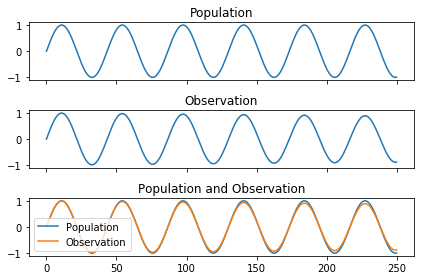

In [3]:
# visualize data
n_plot = int(a.size / 10)

_, axarr = plt.subplots(3, sharex=True, sharey=True)
axarr[0].plot(a[:n_plot])
axarr[0].set_title('Population')
axarr[1].plot(a_decaying[:n_plot])
axarr[1].set_title('Observation')
axarr[2].plot(a[:n_plot], label="Population")
axarr[2].plot(a_decaying[:n_plot], label="Observation")
axarr[2].set_title('Population and Observation')
axarr[2].legend()
plt.tight_layout()
plt.show()

In [53]:
def _load_data(data, n_prev=100, is_shuffled=True):
    docX, docY = [], []
    for series in data:
        for j in range(len(series)-n_prev):
            docX.append(series[j:j+n_prev])
            docY.append(series[j+n_prev])   
    alsX = np.array(docX)
    alsY = np.array(docY)
    if is_shuffled: 
        alsX, alsY = shuffle(alsX, alsY)

    return alsX.reshape(alsX.shape[0], alsX.shape[1], alsX.shape[2]), 
            alsY.reshape(alsY.shape[0], alsY.shape[2])

def train_test_split(data):  
    """
    This just splits data to training and testing parts
    """
    test_id = np.random.randint(0, len(data))
    X_test, y_test = _load_data([data[test_id]], is_shuffled=False)
    data_train = data[:test_id] + data[test_id+1:]
    np.random.shuffle(data_train)
    X_train, y_train = _load_data(data_train, is_shuffled=False)
    
    return (X_train, y_train), (X_test, y_test), (X_model, y_model)

# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data)

In [54]:
# define model structure
model = Sequential()
model.add(Bidirectional(LSTM(units=200, return_sequences=False), input_shape=(None, 1)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=True)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
model.add(Dense(units=1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [56]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.2)

Train on 27036 samples, validate on 6760 samples
Epoch 1/20
27036/27036 [==============================] - 120s 4ms/step - loss: 0.0031 - val_loss: 8.6501e-05
Epoch 2/20
27036/27036 [==============================] - 117s 4ms/step - loss: 3.5537e-05 - val_loss: 1.0362e-05
Epoch 3/20
27036/27036 [==============================] - 117s 4ms/step - loss: 2.1988e-05 - val_loss: 1.2780e-05
Epoch 4/20
27036/27036 [==============================] - 119s 4ms/step - loss: 1.9181e-05 - val_loss: 1.0907e-05
Epoch 5/20
27036/27036 [==============================] - 117s 4ms/step - loss: 1.3675e-05 - val_loss: 1.0187e-05
Epoch 6/20
27036/27036 [==============================] - 115s 4ms/step - loss: 1.0354e-05 - val_loss: 6.1966e-06
Epoch 7/20
27036/27036 [==============================] - 115s 4ms/step - loss: 1.3905e-05 - val_loss: 2.2859e-05
Epoch 8/20
27036/27036 [==============================] - 115s 4ms/step - loss: 1.5018e-05 - val_loss: 6.5587e-06
Epoch 9/20
27036/27036 [===================

In [57]:
# evaluate model fit
score = model.evaluate(X_test, y_test)
print('Test score:', score)

2414/2414 [==============================] - 2s 943us/step
Test score: 6.769461757288254e-07


In [58]:
# visualize predictions
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

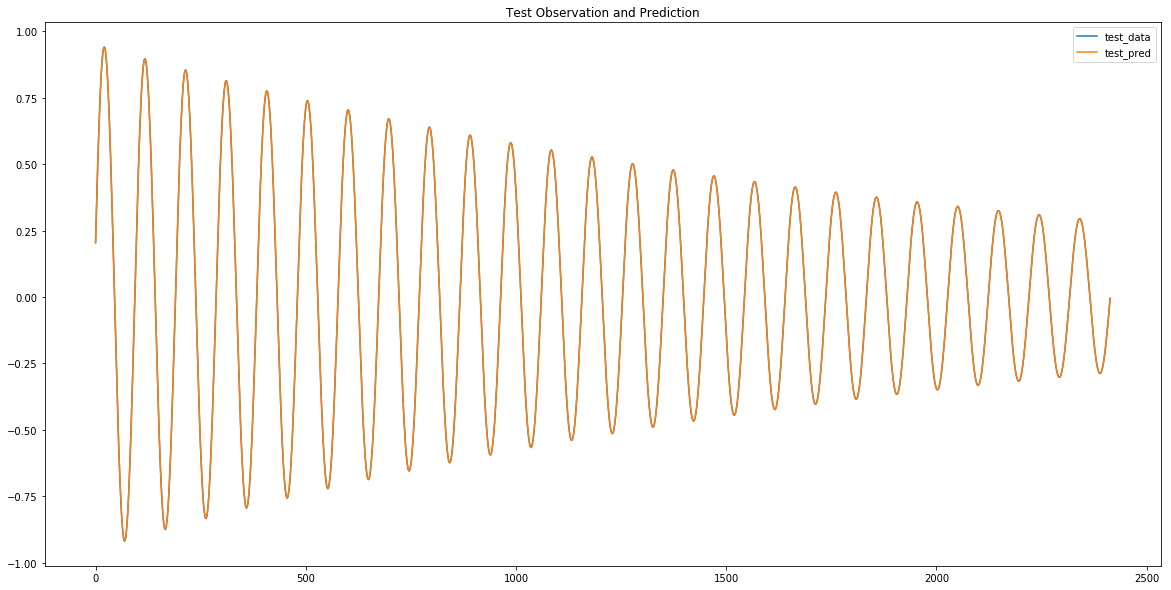

In [59]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:], label='test_data')
plt.plot(test_prediction[:], label='test_pred')
plt.title('Test Observation and Prediction')
plt.legend()

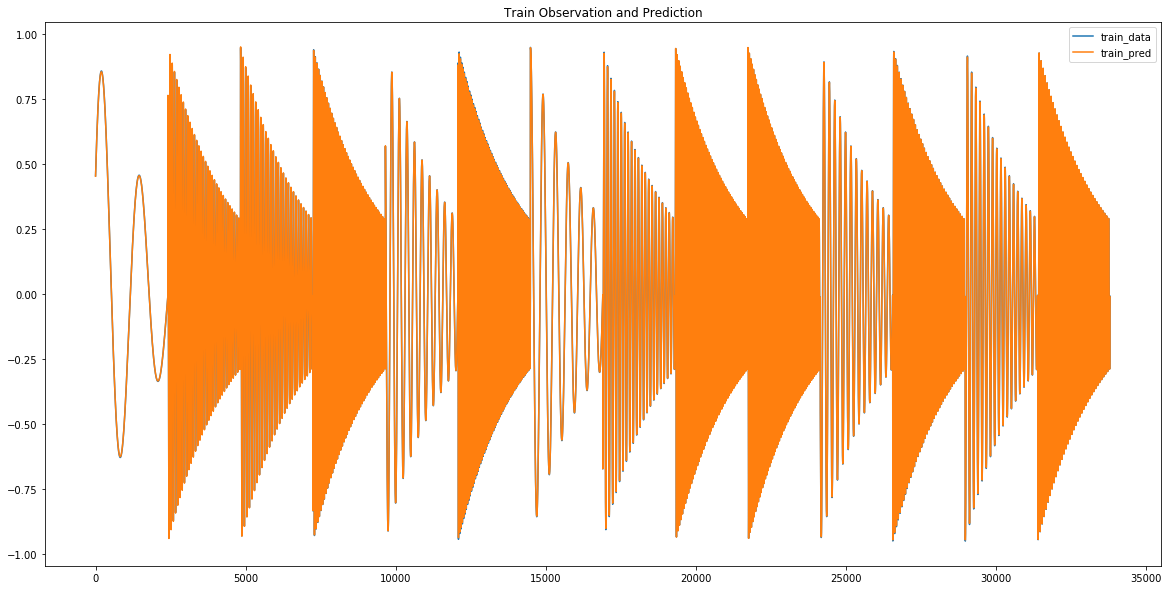

In [60]:
plt.figure(figsize=(20,10))
plt.plot(y_train[:], label='train_data')
plt.plot(train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()